# MNIST with torchvision and skorch

This notebooks shows how to define and train a simple Neural-Network with PyTorch and use it via skorch with the help of torchvision.

<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/github/dnouri/skorch/blob/master/notebooks/MNIST.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/dnouri/skorch/blob/master/notebooks/MNIST.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/github/dnouri/skorch/blob/master/notebooks/MNIST.ipynb), we recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

If you are running in colab, you should install the dependencies and download the dataset by running the following cell:

In [1]:
! [ ! -z "$COLAB_GPU" ] && pip install torch scikit-learn==0.20.* skorch

In [2]:
from itertools import islice

from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt

## Loading Data

Use torchvision's data repository to provide MNIST data in form of a torch `Dataset`. Originally, the `MNIST` dataset provides 28x28 `PIL` images. To use them with PyTorch, we convert those to tensors by adding the `ToTensor` transform.

In [3]:
mnist_train = MNIST('datasets', train=True, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
]))

In [4]:
mnist_test = MNIST('datasets', train=False, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
]))

## Taking a look at the data

Each entry in the `mnist_train` and `mnist_test` Dataset instances consists of a 28 x 28 images and the corresponding label (numbers between 0 and 9). The image data is already normalized to the range [0; 1]. Let's take a look at the first 5 images of the training set:

In [5]:
X_example, y_example = zip(*islice(iter(mnist_train), 5))

In [6]:
X_example[0].min(), X_example[0].max()

(tensor(0.), tensor(1.))

### Print a selection of training images and their labels

In [7]:
def plot_example(X, y, n=5):
    """Plot the images in X and their labels in rows of `n` elements."""
    fig = plt.figure()
    rows = len(X) // n + 1
    for i, (img, y) in enumerate(zip(X, y)):
        ax = fig.add_subplot(rows, n, i + 1)
        ax.imshow(img.reshape(28, 28))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(y)

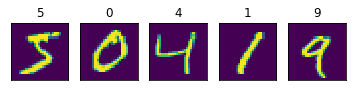

In [8]:
plot_example(torch.stack(X_example), y_example, n=5)

### Preparing a validation split

skorch can split the data for us automatically but since we are using `Dataset`s for their lazy-loading property there is no way skorch can do a stratified split automatically without exploring the data completely first (which it doesn't). 

If we want skorch to do a validation split for us we need to retrieve the `y` values from the dataset and pass these values to `net.fit` later on:

In [9]:
y_train = np.array([y for x, y in iter(mnist_train)])

## Build Neural Network with PyTorch

Simple, fully connected neural network with one hidden layer. Input layer has 784 dimensions (28x28), hidden layer has 98 (= 784 / 8) and output layer 10 neurons, representing digits 0 - 9.

In [10]:
from torch import nn
import torch.nn.functional as F

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mnist_flat_dim = 28 * 28

A simple neural network classifier with linear layers and a final softmax in PyTorch:

In [12]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_flat_dim,
            hidden_dim=98,
            output_dim=10,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        X = X.reshape(-1, self.hidden.in_features)
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

skorch allows to use PyTorch with an sklearn API. We will train the classifier using the classic sklearn `.fit()`:

In [13]:
from skorch import NeuralNetClassifier
from skorch.dataset import CVSplit

In [14]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=10,
    iterator_train__num_workers=4,
    iterator_valid__num_workers=4,
    lr=0.1,
    device=device,
)

In [15]:
net.fit(mnist_train, y=y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7950       0.9000        0.3617  5.4098
      2        0.4229       0.9209        0.2814  5.3074
      3        0.3543       0.9299        0.2412  5.4482
      4        0.3166       0.9380        0.2122  4.8581
      5        0.2868       0.9447        0.1922  4.9590
      6        0.2713       0.9485        0.1799  5.1911
      7        0.2498       0.9516        0.1676  4.9538
      8        0.2403       0.9537        0.1577  5.2120
      9        0.2287       0.9559        0.1515  4.6677
     10        0.2165       0.9574        0.1456  5.2533


## Prediction

In [31]:
from sklearn.metrics import accuracy_score

In [32]:
y_pred = net.predict(mnist_test)
y_test = np.array([y for x, y in iter(mnist_test)])

In [33]:
accuracy_score(y_test, y_pred)

0.9576

An accuracy of about 96% for a network with only one hidden layer is not too bad.

Let's take a look at some predictions that went wrong.

We compute the index of elements that are misclassified and plot a few of those to get an idea
of what went wrong.

In [34]:
error_mask = y_pred != y_test

Now that we have the mask we need a way to access the images from the `mnist_test` dataset. Luckily, skorch provides a helper class that lets us slice arbitrary `Dataset` objects, `SlicedDataset`:

In [35]:
from skorch.helper import SliceDataset

In [36]:
mnist_test_sliceable = SliceDataset(mnist_test)

In [37]:
X_pred = torch.stack(list(mnist_test_sliceable[error_mask]))

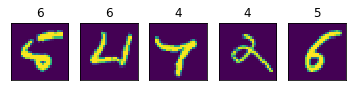

In [38]:
plot_example(X_pred[:5], y_pred[error_mask][:5])

# Convolutional Network

Next we want to turn it up a notch and use a convolutional neural network which is far better
suited for images than simple densely connected layers.

PyTorch expects a 4 dimensional tensor as input for its 2D convolution layer. The dimensions represent:

* Batch size
* Number of channels
* Height
* Width

MNIST data only has one channel since there is no color information. As stated above, each MNIST vector represents a 28x28 pixel image. Hence, the resulting shape for the input tensor needs to be `(x, 1, 28, 28)` where `x` is the batch size and automatically provided by the data loader.

Luckily, our data is already formated that way:

In [42]:
X_example[0].shape

torch.Size([1, 28, 28])

Now let us define the convolutional neural network module using PyTorch:

In [28]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        
        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

As before we can wrap skorch's `NeuralNetClassifier` around our module and start training it like every other sklearn model using `.fit`:

In [39]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn,
    max_epochs=10,
    lr=0.0002,
    optimizer=torch.optim.Adam,
    device=device,
    iterator_train__num_workers=4,
    iterator_valid__num_workers=4,
)

In [40]:
cnn.fit(mnist_train, y=y_train);

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.9210       0.9295        0.2458  22.8442
      2        0.3067       0.9572        0.1484  23.7209
      3        0.2163       0.9649        0.1168  25.0062
      4        0.1777       0.9694        0.1003  25.2137
      5        0.1522       0.9738        0.0879  23.9803
      6        0.1370       0.9764        0.0798  24.8945
      7        0.1255       0.9791        0.0735  24.3985
      8        0.1186       0.9796        0.0691  24.9795
      9        0.1094       0.9804        0.0649  25.1321
     10        0.1036       0.9821        0.0616  25.6325


In [44]:
y_pred_cnn = cnn.predict(mnist_test)

In [45]:
accuracy_score(y_test, y_pred_cnn)

0.9849

An accuracy of >98% should suffice for this example!

Let's see how we fare on the examples that went wrong before:

In [46]:
accuracy_score(y_test[error_mask], y_pred_cnn[error_mask])

0.7193396226415094

Great success! The majority of the previously misclassified images are now correctly identified.

In [47]:
X_pred_cnn = torch.stack(list(mnist_test_sliceable[error_mask]))

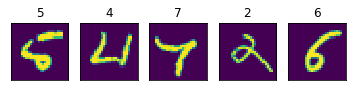

In [49]:
plot_example(X_pred_cnn[:5], y_pred_cnn[error_mask][:5])

# Grid searching parameter configurations

Finally we want to show an example of how to use sklearn grid search when using torch `Dataset` instances.

When doing k-fold validation grid search we have the same problem as before that sklearn is only able to do (stratified) splits when the data is sliceable. While skorch knows how to deal with PyTorch `Dataset` objects and only needs `y` to be known beforehand, sklearn doesn't know how to deal with `Dataset`s and needs a wrapper that makes them sliceable.

Fortunately, we already know that skorch provides such a helper: `SliceDataset`.

What is left to do is to define our parameter search space and run the grid search with a sliceable instance of `mnist_train`:

In [124]:
from sklearn.model_selection import GridSearchCV

In [145]:
params = {
    'module__dropout': [0, 0.5, 0.8],
    'max_epochs': [1],
    'verbose': [False],
}

In [151]:
cnn.initialize();

Re-initializing module.
Re-initializing optimizer.


In [147]:
gs = GridSearchCV(cnn, param_grid=params, scoring='accuracy', verbose=1, cv=3)

In [148]:
mnist_train_sliceable = SliceDataset(mnist_train)

In [149]:
gs.fit(mnist_train_sliceable, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/home/marian/anaconda3/envs/skorch/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.1min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Cnn(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv2_drop): Dropout2d(p=0.5)
    (fc1): Linear(in_features=1600, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=10, bias=True)
    (fc1_drop): Dropout(p=0.5)
  ),
),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'module__dropout': [0, 0.5, 0.8], 'max_epochs': [1], 'verbose': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

After running the grid search we now know the best configuration in our search space:

In [150]:
gs.best_params_

{'max_epochs': 1, 'module__dropout': 0, 'verbose': False}